# Homework2

## Introduction

- This notebook will apply the cleaned dataset from homework 1 and use it to create 3 different models to predict whether an applicant for credit will repay their credit within 2 years.
    - The value 0 indicates that an animal will have a positive outcome (adopted/returned to owner).
    - The value 1 indicates that an animal will have a negative outcome (death).
- Each model will be a supervised learning model and the output will be a binary classification. 
- For each applicant a number of features will be given (independent variables) and the target, risk performance (dependent variable), will be predicted.

This homework will be broken down into 4 main parts:
1. Review the dataset from homework one and decide on which features to use to build our model
2. Create a Linear Regression model and analyse
3. Create a Logistical Regression model and analyse
4. Create a Random Forest model and analyse
5. Try to optimize each model

We will begin by importing the packages needed for this assignment. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

# import graphviz
# from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1) Data Understanding and Prep

The original dataset was cleaned in homework 1 and will now be imported as a starting point for this homework. There are some points to note before proceeding: 

- The cleaned dataset will be a starting point however, some additional cleaning steps will be performed before proceeding with homework2. 
- The data quality report for the cleaned dataset has been provided as a reference. 
- A summary of the data quality plan is seen below. 
- Based on the findings in homework1, four additional features were added. These are: 
    - 'SexKnown' which indicates whether the sex of an animal is known or not. 
    - 'CatOrDog' which indicates whether an animal is either a cat or a dog or not. 
    - 'AgeIntake_bins which grouped the ages of animals upon intake into four equal frequency bins.
    - 'SickOrInjured' which indicates whether an animal was sick/injured or not. 

## Insert data quality plan table here!

We will begin by importing the cleaned dataset from homework 1. 

In [2]:
# read in the cleaned csv
df = pd.read_csv("19205514_cleaned_new_features_added.csv")

We will now look at the first five lines of this dataset. 

In [3]:
df.head(5)

,AnimalID,Name_Provided,DateTime_Intake,FoundLocation,IntakeType,IntakeCondition,AnimalType_Intake,SexuponIntake,AgeuponIntake,Breed_Intake,...,DateTime_Outcome,DateofBirth,SexuponOutcome,AgeuponOutcome,binary_outcome,percent,SexKnown,CatOrDog,AgeIntake_bins,SickOrInjured
0,A687076,Yes,2014-08-30 17:55:00,Austin (TX),Stray,Normal,Cat,Intact Female,76,Domestic Shorthair,...,2014-09-05 14:33:00,2014-06-15 00:00:00,Spayed Female,82,0,0.109769,1,1,"(55.8, 92.0]",0
1,A685139,No,2014-08-03 11:23:00,Austin (TX),Stray,Other,Dog,Intact Female,92,Other Dog Breeds,...,2014-08-07 18:09:00,2014-05-03 00:00:00,Spayed Female,96,0,0.109769,1,1,"(55.8, 92.0]",0
2,A741039,Yes,2016-12-27 11:18:00,Austin (TX),Stray,Normal,Dog,Intact Male,366,Other Dog Breeds,...,2017-01-01 15:27:00,2015-12-27 00:00:00,Intact Male,371,0,0.109769,1,1,"(365.0, 427.6]",0
3,A759166,Yes,2017-09-28 11:03:00,Austin (TX),Stray,Normal,Cat,Intact Male,62,Domestic Shorthair,...,2017-11-04 18:11:00,2017-07-28 00:00:00,Neutered Male,99,0,0.109769,1,1,"(55.8, 92.0]",0
4,A696479,Yes,2015-02-05 11:51:00,Travis (TX),Stray,Normal,Cat,Intact Male,365,Domestic Medium Hair,...,2015-02-15 11:39:00,2014-02-05 00:00:00,Neutered Male,375,0,0.109769,1,1,"(212.0, 365.0]",0


In [4]:
#look at the shape of the dataset
df.shape

(1000, 21)

We will now look at the datatypes of our features after importing the csv. 

In [5]:
df.dtypes

AnimalID              object
Name_Provided         object
DateTime_Intake       object
FoundLocation         object
IntakeType            object
IntakeCondition       object
AnimalType_Intake     object
SexuponIntake         object
AgeuponIntake          int64
Breed_Intake          object
Color_Intake          object
DateTime_Outcome      object
DateofBirth           object
SexuponOutcome        object
AgeuponOutcome         int64
binary_outcome         int64
percent              float64
SexKnown               int64
CatOrDog               int64
AgeIntake_bins        object
SickOrInjured          int64
dtype: object

We can see that the datatpyes of some features have reverted back to type "object". We will now convert these features back to their appropriate types. 

The target feature *binary_outcome* will need to be an int when creating scatter plots further on, so we can leave it as it is. 

In [6]:
#convert all objects to categories
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')

#convert animal ID to an object type
df['AnimalID'] = df['AnimalID'].astype('object')  

#convert the new features 'SexKnown','CatOrDog' and 'SickOrInjured' back to category type as this 
#is how they were implemented in homework1.
new_features = ['SexKnown','CatOrDog', 'SickOrInjured']
for column in new_features:
    df[column] = df[column].astype('category')
    
#convert all date features to datetime types
date_columns = ['DateTime_Intake', 'DateTime_Outcome', 'DateofBirth']
for column in date_columns: 
    df[column] = df[column].astype('datetime64[ns]')
    
#convert binary outcome to category type
# df['binary_outcome'] = df['binary_outcome'].astype('category') 

We will now remove the feature 'percent'. This was generating while implementing bar plots in homework1 and should not be part of the dataset. 

In [7]:
#drop the feature 'percent'
df = df.drop("percent", 1)

### Further cleaning steps

As mentioned above, before going any further there is another cleaning step required. In homework1 the features *DateTime_Intake* and *DateTime_Outcome* were explored. It was found that there were some data integrity issues and these were dealt with in homework1. However, it was not deemed necessary at the time to split these features into categorical features representing the year, month and day. Before proceeding with predictive modelling we will now carry out this step. This step will make it easier to work with the high cardinality of the datetime features and it will convert them to a format which is easier to work with for predictive modelling. 

It is necessary to note that some investigation was done into the month and day of intakei in a temporary dataframe in homework1 and no clear relationship was seen with the binary outcome. However, at this stage in homework2 it is necessary to explore these features further before deciding which ones we will use for predictive modelling. 

We begin this step by converting the feature *DateTime_Intake* into year, month and day features. 

In [8]:
#extract the year, month and day from 'DateTime_Intake'
df['Intake_Year']=df['DateTime_Intake'].dt.year
df['Intake_Month']=df['DateTime_Intake'].dt.month
df['Intake_Day']=df['DateTime_Intake'].dt.day_name()

We will now convert *DateTime_Intake* into year, month and day features. 

In [9]:
#extract the year, month and day from 'DateTime_Outcome'
df['Outcome_Year']=df['DateTime_Outcome'].dt.year
df['Outcome_Month']=df['DateTime_Outcome'].dt.month
df['Outcome_Day']=df['DateTime_Outcome'].dt.day_name()

We will now convert these new features to type 'category'.

In [10]:
#convert new features to category type
new_date_features = ['Intake_Year','Intake_Month', 'Intake_Day', 'Outcome_Year', 'Outcome_Month', 'Outcome_Day']
for column in new_date_features: 
    df[column] = df[column].astype('category')

In [11]:
df.dtypes

AnimalID                     object
Name_Provided              category
DateTime_Intake      datetime64[ns]
FoundLocation              category
IntakeType                 category
IntakeCondition            category
AnimalType_Intake          category
SexuponIntake              category
AgeuponIntake                 int64
Breed_Intake               category
Color_Intake               category
DateTime_Outcome     datetime64[ns]
DateofBirth          datetime64[ns]
SexuponOutcome             category
AgeuponOutcome                int64
binary_outcome                int64
SexKnown                   category
CatOrDog                   category
AgeIntake_bins             category
SickOrInjured              category
Intake_Year                category
Intake_Month               category
Intake_Day                 category
Outcome_Year               category
Outcome_Month              category
Outcome_Day                category
dtype: object

The features *DateTime_Intake* and *DateTime_Outcome* were of type datetime64. The new year, month and day features extracted from these have a much lower cardinality and are in a format that is much more useful for predictive modelling. 

We can now drop the original features *DateTime_Intake* and *DateTime_Outcome* as we have extracted all important information and no information will be lost. 

In [12]:
#drop the features 'DateTime_Intake' and'DateTime_Outcome'
df = df.drop('DateTime_Intake', 1)
df = df.drop('DateTime_Outcome', 1)

Furthermore, the feature *DateofBirth* was used to calculate the features *AgeuponIntake* and *AgeuponOutcome*. This feature will not be needed for predictive modelling as the information we need is represented by the age features. As a result, we will now drop this feature. 

In [13]:
#drop 'DateofBirth'
df = df.drop('DateofBirth', 1)

We will also now drop the feature 'AnimalID'as this is only needed for reference purposes and is not helpful in predictive modelling. 

In [14]:
#drop 'AnimalID'
df = df.drop('AnimalID', 1)

Missing values were dealt with in homework1. However, we will now check to ensure that there are currently no missing values in our dataset. 

In [15]:
df.isna().sum()

Name_Provided        0
FoundLocation        0
IntakeType           0
IntakeCondition      0
AnimalType_Intake    0
SexuponIntake        0
AgeuponIntake        0
Breed_Intake         0
Color_Intake         0
SexuponOutcome       0
AgeuponOutcome       0
binary_outcome       0
SexKnown             0
CatOrDog             0
AgeIntake_bins       0
SickOrInjured        0
Intake_Year          0
Intake_Month         0
Intake_Day           0
Outcome_Year         0
Outcome_Month        0
Outcome_Day          0
dtype: int64

We can see that there are no missing values. We will now check the datatypes again before proceeding with plots.

In [16]:
df.dtypes

Name_Provided        category
FoundLocation        category
IntakeType           category
IntakeCondition      category
AnimalType_Intake    category
SexuponIntake        category
AgeuponIntake           int64
Breed_Intake         category
Color_Intake         category
SexuponOutcome       category
AgeuponOutcome          int64
binary_outcome          int64
SexKnown             category
CatOrDog             category
AgeIntake_bins       category
SickOrInjured        category
Intake_Year          category
Intake_Month         category
Intake_Day           category
Outcome_Year         category
Outcome_Month        category
Outcome_Day          category
dtype: object

We will now setup our categorical and continuous features. These will be needed for plotting and for the creation of dummies later. 

In [17]:
categorical_features = df.select_dtypes(['category']).columns
continuous_features = ['AgeuponIntake', 'AgeuponOutcome']

## Setup continuous and categorical types for plotting later? 

### (1.1) Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

Sklearn train_test_split randomly shuffles the dataset. However, we will implement an additional shuffling step beforehand as specified in the requirements. 

In [18]:
# randomly generate a sequence based on the dataframe index. Set this to be the new index.
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
#Look at the first five rows of the randomly shuffled dataset
df.head(5)

,Name_Provided,FoundLocation,IntakeType,IntakeCondition,AnimalType_Intake,SexuponIntake,AgeuponIntake,Breed_Intake,Color_Intake,SexuponOutcome,...,SexKnown,CatOrDog,AgeIntake_bins,SickOrInjured,Intake_Year,Intake_Month,Intake_Day,Outcome_Year,Outcome_Month,Outcome_Day
0,Yes,Austin (TX),Stray,Normal,Cat,Intact Female,76,Domestic Shorthair,Mixed Pattern,Spayed Female,...,1,1,"(55.8, 92.0]",0,2014,8,Saturday,2014,9,Friday
1,No,Austin (TX),Stray,Other,Dog,Intact Female,92,Other Dog Breeds,White,Spayed Female,...,1,1,"(55.8, 92.0]",0,2014,8,Sunday,2014,8,Thursday
2,Yes,Austin (TX),Stray,Normal,Dog,Intact Male,366,Other Dog Breeds,Black,Intact Male,...,1,1,"(365.0, 427.6]",0,2016,12,Tuesday,2017,1,Sunday
3,Yes,Austin (TX),Stray,Normal,Cat,Intact Male,62,Domestic Shorthair,Black,Neutered Male,...,1,1,"(55.8, 92.0]",0,2017,9,Thursday,2017,11,Saturday
4,Yes,Travis (TX),Stray,Normal,Cat,Intact Male,365,Domestic Medium Hair,Black,Neutered Male,...,1,1,"(212.0, 365.0]",0,2015,2,Thursday,2015,2,Sunday


**The dataset will now be split into two separate datasets - 70% training and 30% test.**
- We set the target feature "y" to be "binary_outcome"
- We feature "x" to be all remaining features in the dataset. The feature "binary_outcome" will be excluded.

In [19]:
y = pd.DataFrame(df["binary_outcome"])
X = df.drop(["binary_outcome"],1)

We will now split the dataset. The parameter 'test-size' will determine the size of the training and test datasets. We will set this to 0.3 in order to split into 70% training and 30% test. The parameter 'random_state' sets a seed to the train_test_split random generator. We will set this parameter to 1 to ensure that the train/test split is the same each time this code is executed.  

In [20]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000


We are now ready to plot the features. 

#### (1.2) On the training set - For each continuous feature, plot its interaction with the target feature. Discuss what you observe from these plots. Choose a subset of continuous features you find promising (if any). Justify your choices.

All plots will be generated using on the training subset created above - X_train, y_train. The testing subset will be left aside. 

#### 1.2.1 Plot correlation between continous features and target feature. 

In our dataset, we only have two continous features. These are *AgeUponIntake* and *AgeUponOutcome*. As a result, a correlation matrix will not be useful. Instead, we will now plot both of these features against the target outcome. 

- We will now loop over both continuous features and plot them against the target *binary_outcome*. 
- We will discuss our findings from these plots and choose a subset (if any) of the feature(s) which seem promising. 
- To begin, we will convert the target feature to an int as this is necessary for the below plot. 

In [21]:
#convert binary outcome to int type
y_train = y_train.astype("int64")

,binary_outcome
AgeuponIntake,0.011775
AgeuponOutcome,0.008967


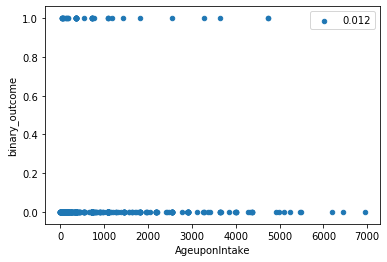

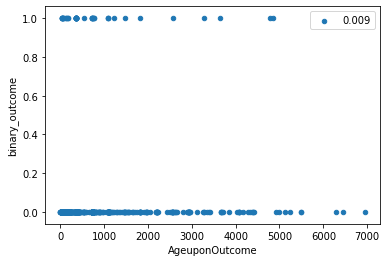

In [22]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_features]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
corr_df

#### 1.2.2 Interpretation of the results

- We can see that there is no clearly defined correlation between either feature and the target feature. This isunderstandable given the large range of ages and the variety of animals which the ages represent. 
- The sorted correlation dataframes above the plots give an even clearer indication of the results. We can see that the correlation between both features and the target outcome is below 0.012.
- It must be noted however, that as described in section 3.6.1 of the FMLPD course textbook, continuous features that cover very different ranges should be normalised. As we are dealing with the ages of many different species of animals, normalisation would cause these two continous features to fall within a specified range while maintaining the relative differences between the values for the feature. In other words, adding a normalisation step would better represent the different between an old dog and an old racoon, for example. 
- At this stage in the assignment we are choosing the leave the ages at their absolute values as it will also be important to see if they predict well in the model. Later in the assignment we will implement normalisation and make a comparision. 
- Furthermore, at the end of homework1, a new feature was created which divided the ages into equal fequency bins. It will be interesting to see if a stronger correlation is seen between those new values and the target feature. 
- For now, we will keep these features as they are. 

#### 1.2.3 Plot interaction between categorical features and target feature.

- We will now plot a pairwise interaction between each categorical feature and the target feature. 
- We will discuss which features seem to be better at predicting the target feature and will choose a subset of feature we find promising.
- As with the plots of continuous features above, only the training dataset will be used. 
- To create these plots we will work with the variable *categorical_features* created above. 
- We will begin by converting the target feature to a categorical type as this is required for these plots. 

In [23]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")


 Name_Provided
Index 	 Count
No 	 211
Yes 	 489

 FoundLocation
Index 	 Count
Austin (TX) 	 582
Pflugerville (TX) 	 15
Manor (TX) 	 16
Travis (TX) 	 52
Other 	 8
Del Valle (TX) 	 20
Outside Jurisdiction 	 7

 IntakeType
Index 	 Count
Stray 	 507
Wildlife 	 22
Owner Surrender 	 132
Public Assist 	 38
Euthanasia Request 	 1

 IntakeCondition
Index 	 Count
Normal 	 629
Injured 	 30
Sick 	 25
Nursing 	 15
Other 	 1

 AnimalType_Intake
Index 	 Count
Dog 	 398
Bird 	 2
Bat 	 21
Cat 	 268
Other 	 11

 SexuponIntake
Index 	 Count
Intact Male 	 237
Intact Female 	 226
Unknown 	 49
Neutered Male 	 101
Spayed Female 	 87

 Breed_Intake
Index 	 Count
Labrador Retriever 	 43
Other animals 	 13
Bat 	 21
Domestic Shorthair 	 216
Other Dog Breeds 	 216
Pit Bull 	 47
Chihuahua Shorthair 	 54
Domestic Medium Hair 	 18
Miniature Poodle Mix 	 9
German Shepherd 	 11
Border Collie Mix 	 8
Siamese 	 11
Other Cat Breeds 	 16
Boxer Mix 	 10
Domestic Longhair 	 7

 Color_Intake
Index 	 Count
Black 	 156
Brown 

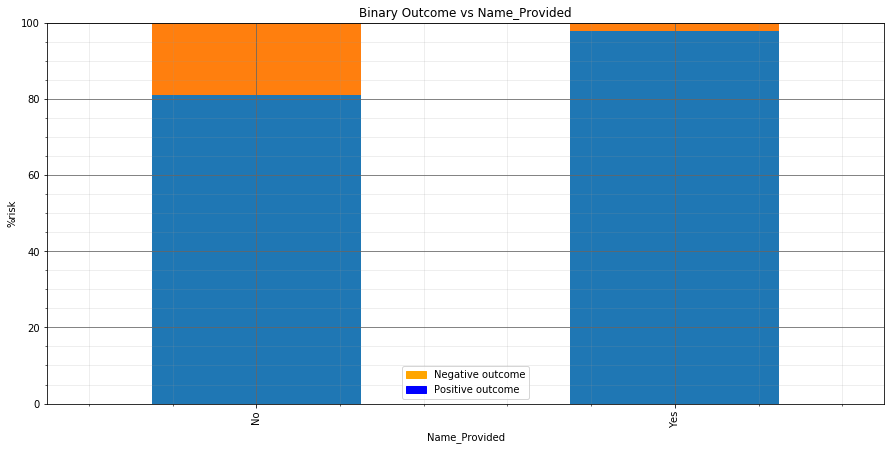

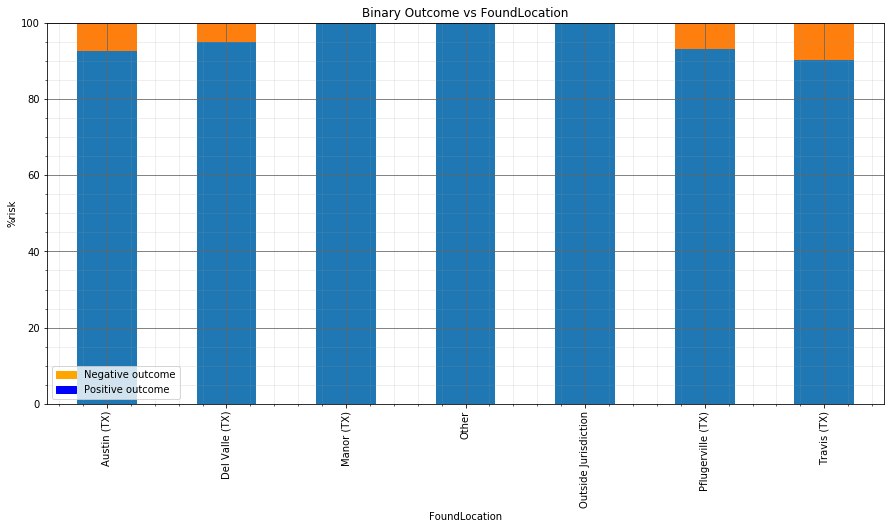

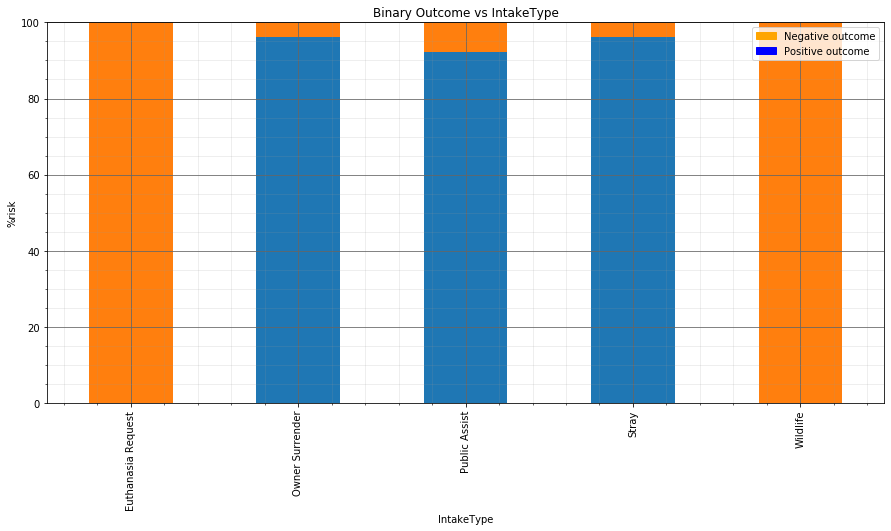

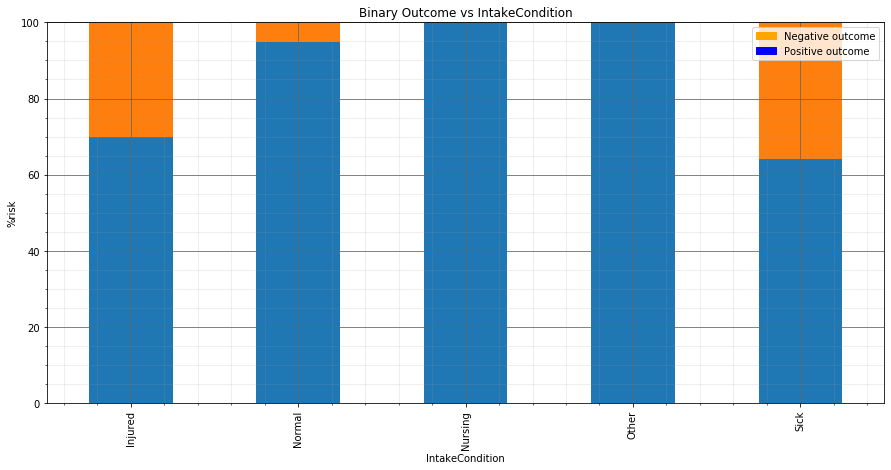

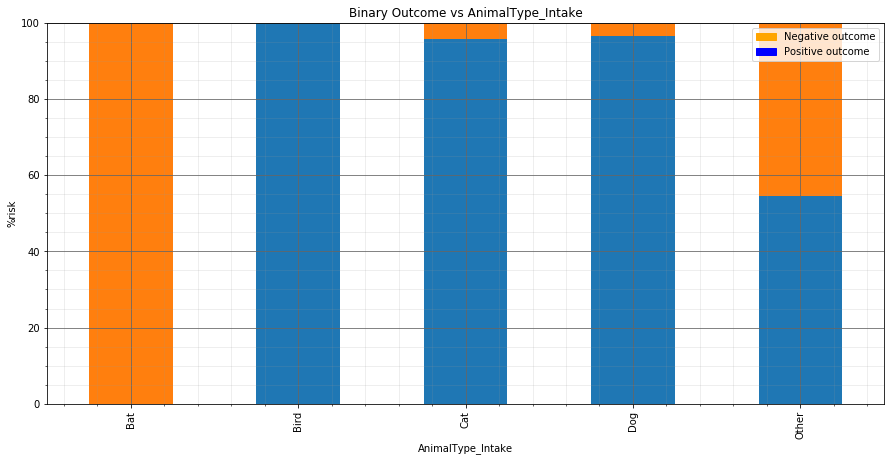

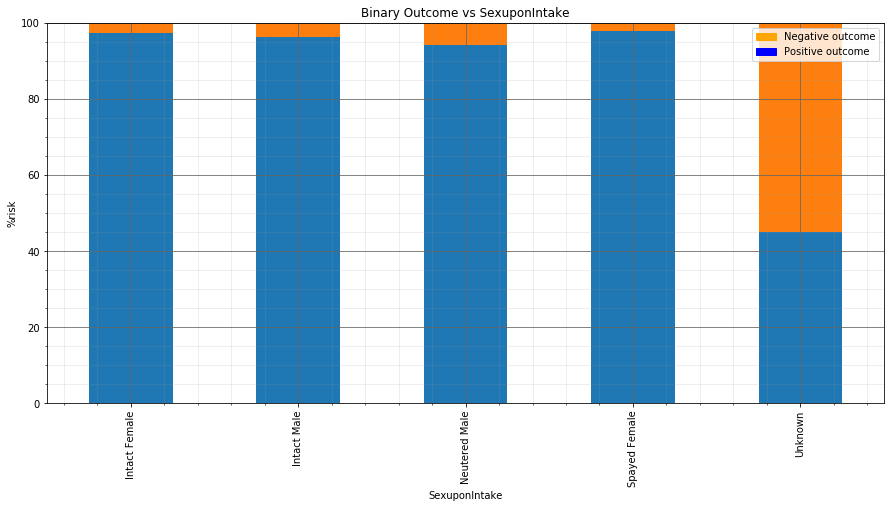

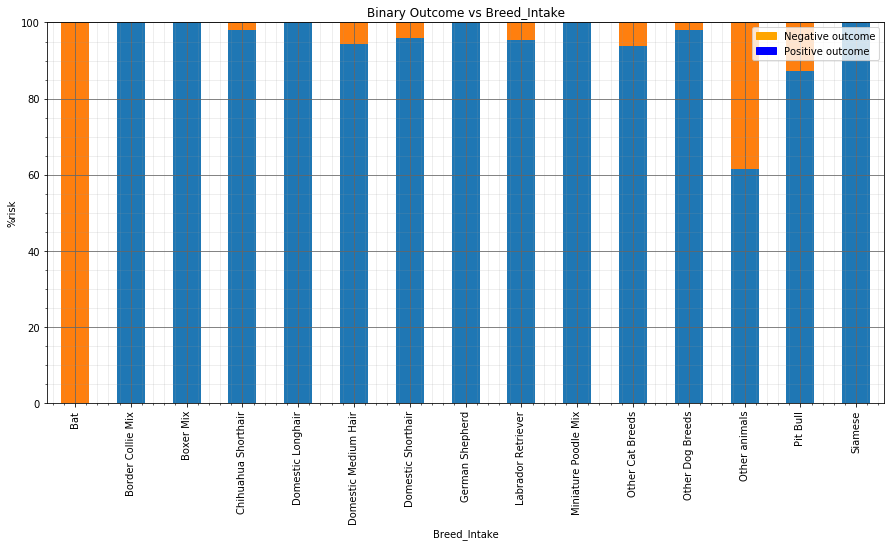

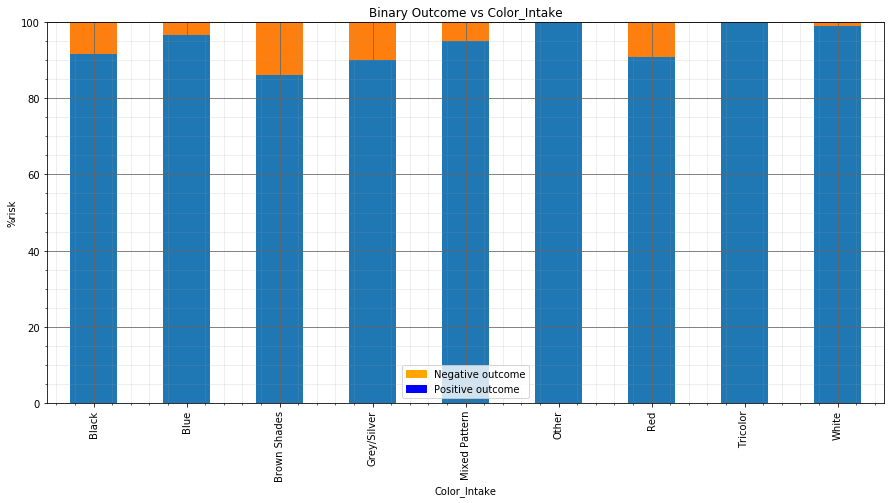

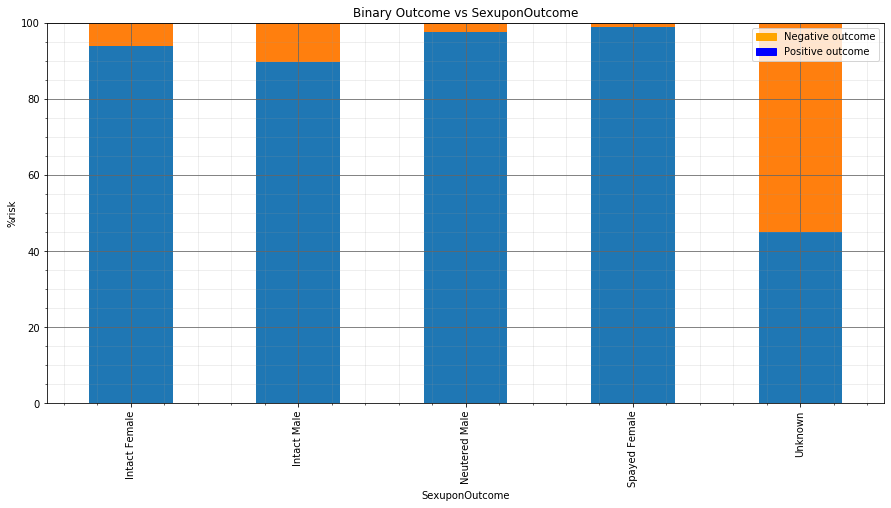

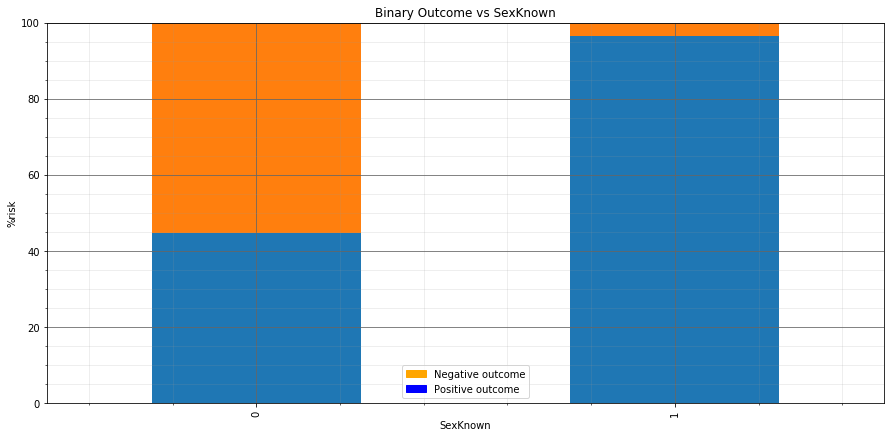

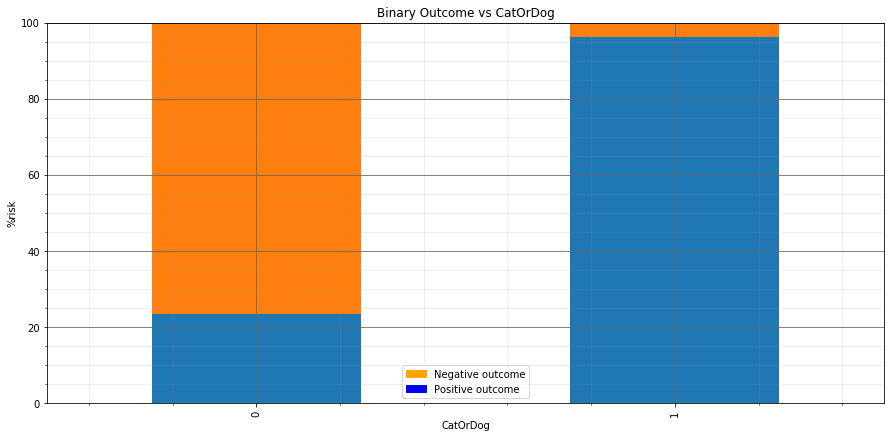

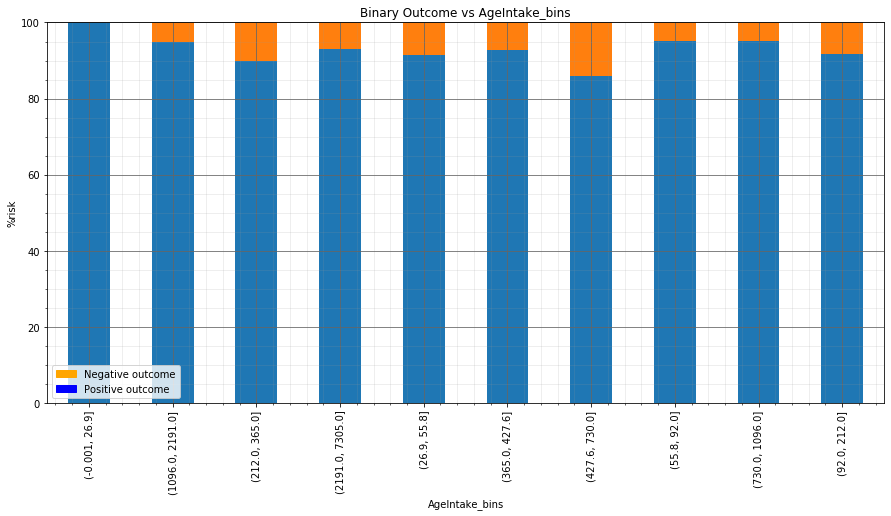

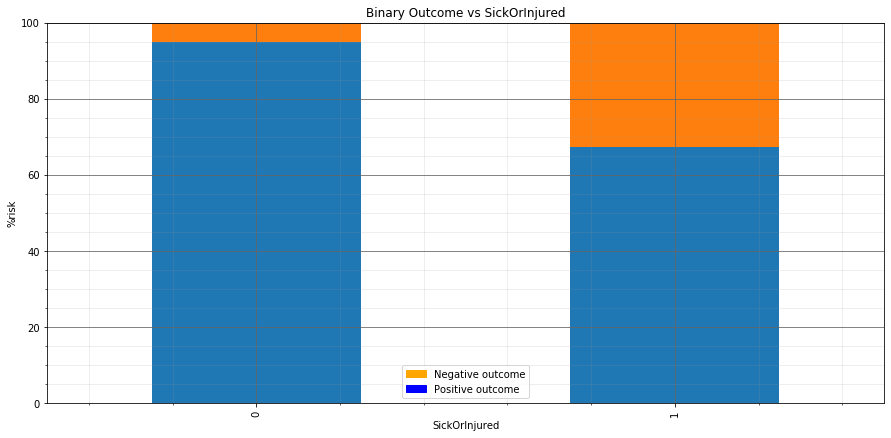

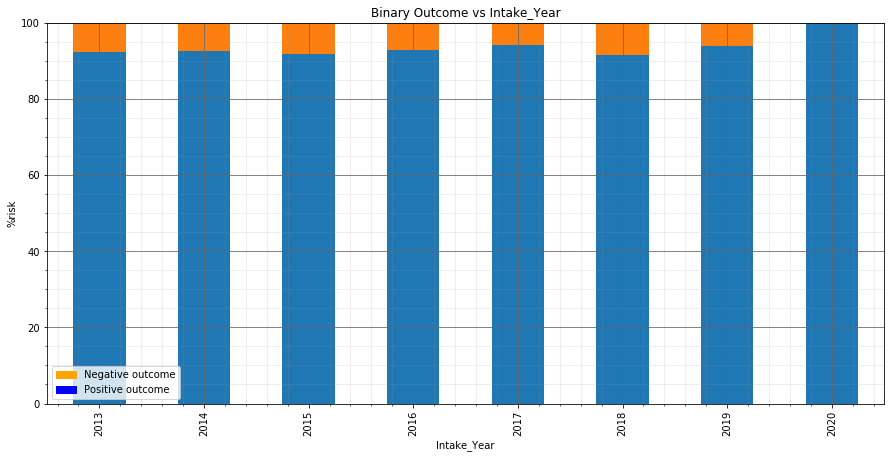

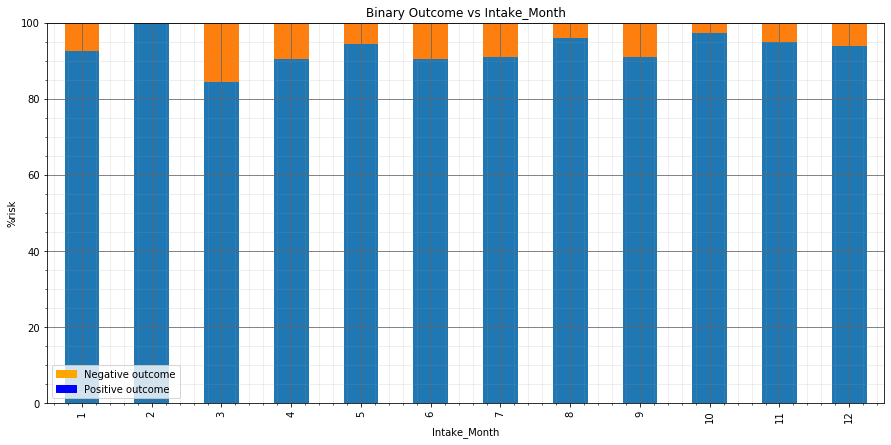

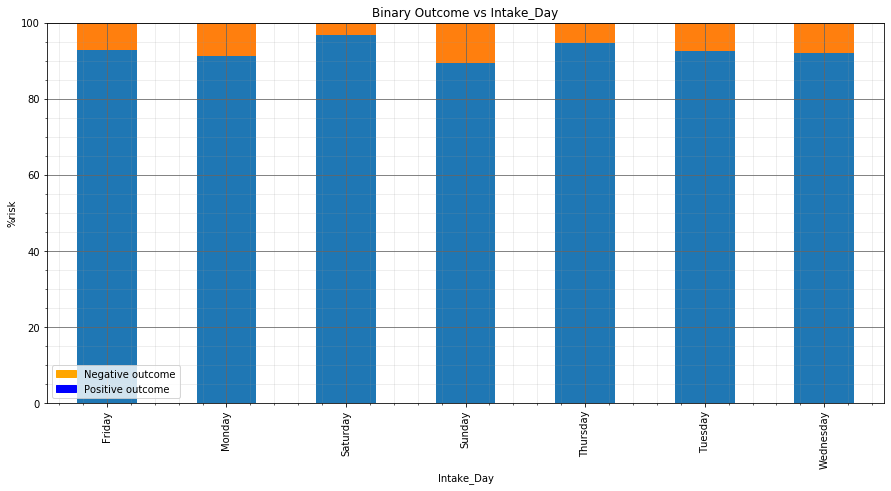

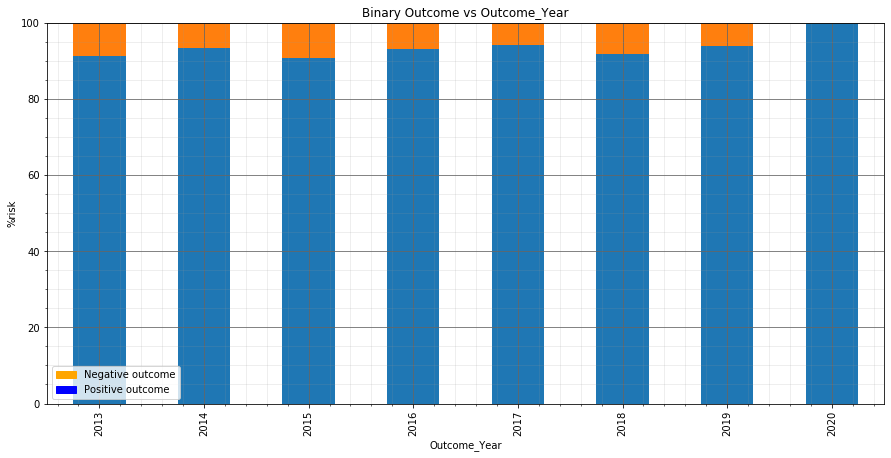

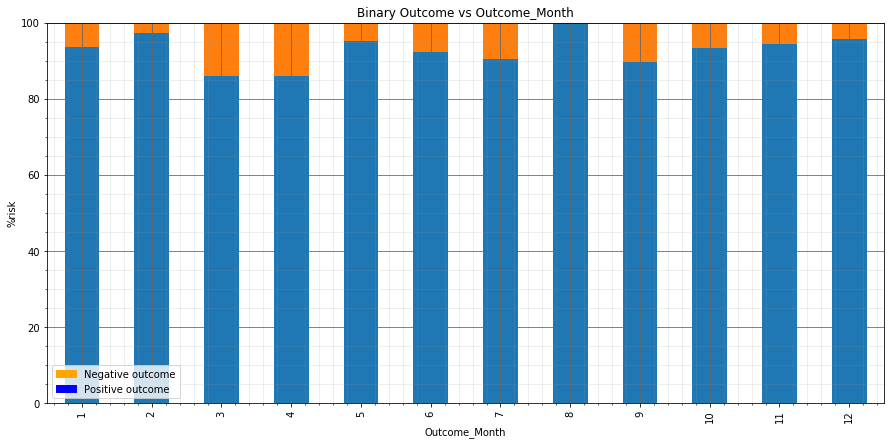

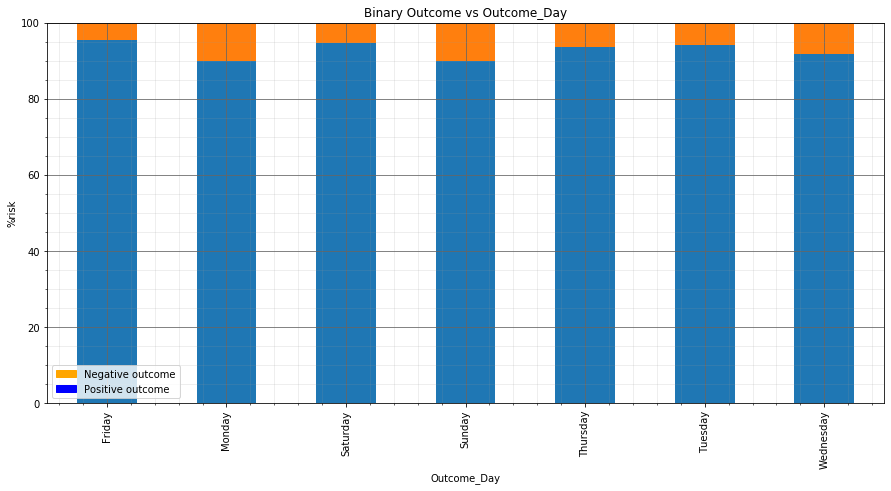

In [24]:
X_train[categorical_features].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_features:
    # Using code from the module lab

    values = pd.unique(df_temp[categorical_feature].ravel())

    # create percent column and initalise to 0
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # loop through each value in the feature col1
    for i in values:

        count = df_temp[df_temp[categorical_feature] == i].count()['binary_outcome']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'binary_outcome']].groupby([categorical_feature,'binary_outcome']).sum()

    #plot the results
    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"Binary Outcome vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Negative outcome')
    blue_patch = mpatches.Patch(color='blue', label='Positive outcome')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines to make the plots easier to visualise
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    my_plot.set_xlabel(categorical_feature)
    my_plot.set_ylabel("%risk")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### 1.2.4 Interpretation of the results

As we have a lot of categorical features, we will only give a brief discussion of each. 

##### Name_Provided vs binary Outcome
We can see that animals with no name are 20% more likely to have a negative outcome. When looking at the absolute values we can see that in this training dataset 211 animals had no name and 489 animals had a name. 

##### Found Location vs binary Outcome
- We can see that if an animal is found in Austin, Del Valle, Pflugerville or Travis, they are 5-10% more likely to have a negative outcome than if found at the other locations. In fact, we see no negaitve outcome at any other locations. 
- Upon examination of the counts however, we can see that this is most likely due to the cities mentioned having a much larger representation. 

##### Intake Type vs binary Outcome
- We can see here that intake type has some interesting findings. As expected, all euthenasia requests result in a negative outcome. Interestingly, all animals with intake type *Wildlife* also have a negative outcome. 
- We assume that this feature is a strong predictor of the binary outcome. 

##### Intake Condition vs binary Outcome
- Here we can see that if an animal is sick or injured, they are 40-50% more likely to have a negative outcome. Although when looking at the absolute values, we can see that the sick or injured animals only make up approximately 10% of the total, the graphs show that this feature still seems like a strong predictor.

##### Animal Type Intake vs binary Outcome
- We see in this plot that animals of type *Bat* or *Other* are 100% and 45% more likely to have a negative outcome, respecitvely, than animals of type *Bird, Cat* or *Dog*. 

##### Sex Upon Intake/Sex upon Outcome vs binary Outcome
- In the graphs for both *SexUponIntake* and *SexUponOutcome* we can see that animals with a value of *Unknown* are 55% more likely to have a negative outcome. 
- We assume that this feature will be a strong indicator of the binary outcome. 
- However, it also seems likely that the most predictive aspect of this feature is whether or not the sex is known. As discussed above, a new feature *SexKnown* has been created to capture this information. 
- We will interpret the graph for that feature shortly. It is possible that these original features will no longer be useful if we have the new feature. 

##### Breed_Intake vs binary Outcome
- We can see that *Bat* breeds and breeds of other animals are more likely to have a negative outcome. This is unsurprising after analysing the *AnimalType_Intake* plot. 
- We also learn from this graph that *Pit Bull* dogs are 12% more likely to have a negative outcome that most other dog breeds. 
- Surprisingly, there are no strong relationships between other dog breeds or any cat breeds and the binary outcome. 

##### Color_Intake vs binary Outcome
- We can see that there are no strinkingly strong relationships between a color and the binary outcome. 
- We can see however, that *Brown* has the worst outcome while *White* animals are more likely to be adopted or returned to their owner. These findings are not surprising based on our understanding of popular pet colours. 

##### New feature vs binary Outcome
- We will now observe the graphs for the four new features created in homework1. 
- **SexKnown**: We can see that if the sex of the animal is not known, there is a 50% higher likelihood of a negative outcome.
- **CatOrDog**: Observing this plot we can see that if an animal is not a cat or a dog they are 80% more likely to have a negative outcome. 
- **AgeIntake_bins**: We can see that there is not as much variation as expected between the different ages. However, we can see that animals between 212 and 730 days have the highest likelihood of a negative outcome.
- **SickOrInjured**: We can see from the plot that if an animal is sick or injured when entering the shelter, they are 15% more likely to have a negative outcome. 

##### Year, Month, Day features
- Observing the plots for both year of intake and outcome we see no clear relationship between the year and the binary outcome.
- Similarly, observing the plots for both month of intake and outcome we see no clear trend. We can see that for Month of intake, March has the highest likelihood of a negative outcome. For month of outcome March and April have the highest likelihoof of a negative outcome. This is possibly due to it being shortly after Christmas, when people no longer want pets given as Christmas gifts. Although not very significant we can also see that there is a slightly more negative outcome in the summer months. I am assuming that this is because of animal breeding seasons, resulting in more strays entering the shelter.
- In the plots for both weekday of intake and outcome we see some variation in the relationship with the binary outcome however, there is no clear trend. 

#### 1.2.5 Summary and drop features

We will now summarise all of the findings from the plots above and drop any features if necessary at this stage. 

1. From continuous vs target feature plots (1.2.1) we saw that neither of the two features *AgeUponIntake* or *AgeUponOutcome* showed a high correlation with the target feature. However, we will not remove these features at this stage for the following reasons: 
 - As we are dealing with complex features involving the ages of many different breeds of animals, we cannot yet say for certain that it has no effect on the outcome. 
 - We wish to compare the findings to the new feature *AgeIntake_bins*.
 - Later in the assignment we will explore normalisation of ages and we will wish to compare to the absolute values. 
 
2. From categorical vs target feature (1.2.3) we saw that the following features did not show a clear relationship with the target feature: 
- FoundLocation
- SexUponIntake (The useful information is being captured in the new feature *SexKnown*)
- SexUponOutcome (The useful information is being captured in the new feature *SexKnown*)
- Intake_Year
- Outcome_Year


We will leave all other categorical features in for now. However we expect *Name_provided*, *IntakeType*, *IntakeCondition*, *AnimalType_Intake*, *Breed_Intake* and the new features *SexKnown*, *CatOrDog* and *SickOrInjured* to have the greatest effect. 

We will now create a list of the low information categorical features listed above. 

In [25]:
low_information_gain = ['FoundLocation', 'SexuponIntake', 'SexuponOutcome', 'Intake_Year', 'Outcome_Year']

We will now drop the low impact categorical features listed above. 

- Before dropping we will duplicate the original dataframe *df* and label the duplicate as *df_version1*
- We will drop features from the duplicate *df_version1* only.
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset *df_version1* with the original dataset *df*.


In [26]:
# drop the low impact categorical features
low_value_features = list(set(low_information_gain))
# before dropping make copy of original
df_version1 = df.copy()
# drop low value features
df_version1.drop(low_value_features, 1, inplace=True)
print('\nRemaining columns:', df_version1.columns)
print('\nNew shape:', df_version1.shape)


Remaining columns: Index(['Name_Provided', 'IntakeType', 'IntakeCondition', 'AnimalType_Intake',
       'AgeuponIntake', 'Breed_Intake', 'Color_Intake', 'AgeuponOutcome',
       'binary_outcome', 'SexKnown', 'CatOrDog', 'AgeIntake_bins',
       'SickOrInjured', 'Intake_Month', 'Intake_Day', 'Outcome_Month',
       'Outcome_Day'],
      dtype='object')

New shape: (1000, 17)


### 1.3 Prepare the dataset for modelling

Now we have picked our descriptive features for the whole dataset, we will now carry out a number of additional steps in order to prepare the dataset for modelling: 
- Convert the categorical variables into dummies variables so that they can be used for modelling.
- Remove the redundant dummies which contain no additional information.
- Set up up the train test split again based on the dataset with the dummies included.

We will now go through these steps in more detail. 

Firstly, as described in section 7.4.3 of the course textbook 'Fundamentals of Machine Learning for Predictive Data Analytics', the most common approach to handling categorical features in regression models is to use a transformation that converts a single cateogrical feature into a number of continuous features that can encode the levels of the categorical feature. The levels of the categorical feature are encoded by setting the value of the new continuous feature which corresponds to the level of the categorical feature to 1, and the other continious features to 0. This is known as *dummy encoding* and is the approoach we will now take. 

The downside of this approach however, is that it creates a lot of new features in the dataset. In other words, as we will see in the linear regression steps below, it creates many new weights for which optimal values must be found. For this reason we carry out the second step above - remove the redundant dummies which contain no additional information. For example, we can assume that a zero in all new features implies that the original cateogrical feature had the first value. We will add the parameter *drop_first = True* in the code below in order to execute this step. 

In [27]:
# set up dummies features
df_version1 = pd.get_dummies(df_version1)
df_version1.dtypes

AgeuponIntake            int64
AgeuponOutcome           int64
binary_outcome           int64
Name_Provided_No         uint8
Name_Provided_Yes        uint8
                         ...  
Outcome_Day_Saturday     uint8
Outcome_Day_Sunday       uint8
Outcome_Day_Thursday     uint8
Outcome_Day_Tuesday      uint8
Outcome_Day_Wednesday    uint8
Length: 98, dtype: object